# Generate 100 random seqs using olga

In [1]:
# If needed:
# pip install olga pandas

import os
import pandas as pd

from olga.load_model import GenomicDataVDJ, GenerativeModelVDJ
from olga.generation_probability import GenerationProbabilityVDJ
from olga.sequence_generation import SequenceGenerationVDJ

# ---------- Config ----------
N = 100
out_dir = "/Users/ishaharris/Projects/TCR/TCR-Isha/data/High_Confidence_CMV_TCR"
out_path = os.path.join(out_dir, "olga_random.tsv")

# ---------- Locate packaged human TRB model ----------
try:
    from importlib.resources import files
    model_dir = str(files("olga") / "default_models" / "human_T_beta")
except Exception:
    import olga as _olga
    model_dir = os.path.join(os.path.dirname(_olga.__file__), "default_models", "human_T_beta")

def pick_anchor(model_dir: str, basename: str) -> str:
    """Return existing anchor path (.csv preferred, else .txt)."""
    csv_path = os.path.join(model_dir, f"{basename}.csv")
    txt_path = os.path.join(model_dir, f"{basename}.txt")
    if os.path.exists(csv_path):
        return csv_path
    if os.path.exists(txt_path):
        return txt_path
    raise FileNotFoundError(
        f"Missing anchors: {basename}.csv/.txt not found in {model_dir}. "
        f"Found: {sorted(os.listdir(model_dir))}"
    )

params_file     = os.path.join(model_dir, "model_params.txt")
marginals_file  = os.path.join(model_dir, "model_marginals.txt")
V_anchor_file   = pick_anchor(model_dir, "V_gene_CDR3_anchors")
J_anchor_file   = pick_anchor(model_dir, "J_gene_CDR3_anchors")

# ---------- Load OLGA model/data ----------
genomic_data = GenomicDataVDJ()
genomic_data.load_igor_genomic_data(params_file, V_anchor_file, J_anchor_file)

generative_model = GenerativeModelVDJ()
generative_model.load_and_process_igor_model(marginals_file)

# Engines for pgen + generation
pgen_model = GenerationProbabilityVDJ(generative_model, genomic_data)
seq_gen_model = SequenceGenerationVDJ(generative_model, genomic_data)

# Helper: AA Pgen (unconstrained by V/J)
def pgen_aa(seq: str) -> float:
    try:
        return pgen_model.compute_aa_CDR3_pgen(seq)
    except TypeError:
        # Some OLGA versions accept (seq, v, j)
        return pgen_model.compute_aa_CDR3_pgen(seq, None, None)

# ---------- Generate sequences & compute Pgen ----------
rows = []
for _ in range(N):
    # gen_rnd_prod_CDR3 returns: (ntseq, aaseq, V_index, J_index)
    ntseq, aaseq, V_idx, J_idx = seq_gen_model.gen_rnd_prod_CDR3()
    pgen = pgen_aa(aaseq)
    rows.append(
        {
            "ntseq": ntseq,
            "aaseq": aaseq,
            "V_index": V_idx,
            "J_index": J_idx,
            "pgen_aa": pgen,
        }
    )

df = pd.DataFrame(rows)

# ---------- Save ----------
os.makedirs(out_dir, exist_ok=True)
df.to_csv(out_path, sep="\t", index=False)
print(f"Saved {len(df)} sequences to: {out_path}")


Saved 100 sequences to: /Users/ishaharris/Projects/TCR/TCR-Isha/data/High_Confidence_CMV_TCR/olga_random.tsv


### Distribution of pgens

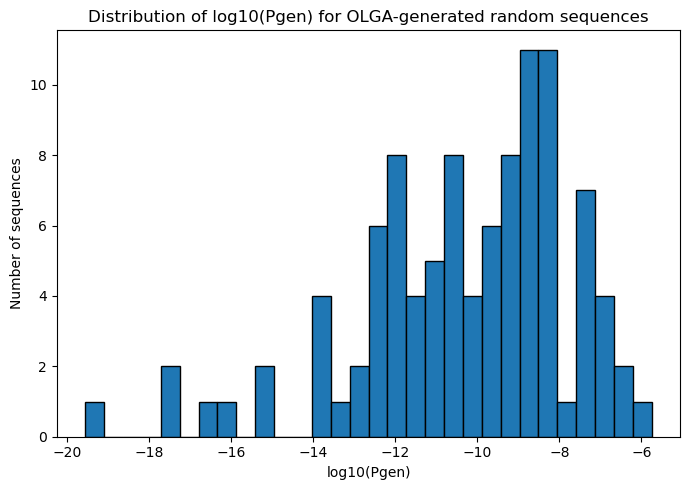

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Paths ----------
out_dir = "/Users/ishaharris/Projects/TCR/TCR-Isha/data/High_Confidence_CMV_TCR"
out_path = os.path.join(out_dir, "olga_random.tsv")

# ---------- Load data ----------
df = pd.read_csv(out_path, sep="\t")

# ---------- Convert to log10(Pgen) ----------
log10_pgen = df["pgen_aa"].apply(lambda x: np.log10(x) if x > 0 else -np.inf)

# ---------- Plot histogram ----------
plt.figure(figsize=(7,5))
plt.hist(log10_pgen, bins=30, edgecolor="black")

plt.xlabel("log10(Pgen)")
plt.ylabel("Number of sequences")
plt.title("Distribution of log10(Pgen) for OLGA-generated random sequences")

plt.tight_layout()
plt.show()
